In [4]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm

# Set Seaborn
sns.set()

# Monte Carlo Method

Text(0.5, 1.0, 'Monte Carlo Simulation of Geometric Brownian Motion')

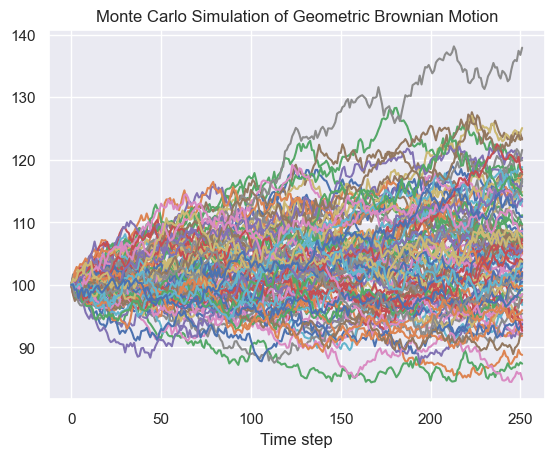

In [5]:
def simulate_path(s0, mu, sigma, horizon, timesteps, n_sims):

    # set the random seed for reproducibility
    np.random.seed(10000)

    # read parameters
    S0 = s0                 # initial spot price
    r = mu                  # mu = rf in risk neutral framework
    T = horizon             # time horizon
    t = timesteps           # number of time steps
    n = n_sims              # number of simulation

    # define dt
    dt = T/t                # length of time interval

    # simulate 'n' asset price path with 't' timesteps
    S = np.zeros((t, n))
    S[0] = S0

    for i in range(0, t-1):
        w = np.random.standard_normal(n)
        S[i+1] = S[i]*np.exp((mu - (sigma**2)/2)*dt + sigma*w*np.sqrt(dt))

    return S

S0 = 100; r = 0.05; sigma = 0.1; T = 1
S = simulate_path(S0, r, sigma, T,252,100000)

price_paths = pd.DataFrame(S)

fig, ax = plt.subplots()
ax.plot(price_paths.loc[:, 0:100]);
ax.set_xlabel("Time step")
ax.set_title("Monte Carlo Simulation of Geometric Brownian Motion")

In [6]:
K = S0
P0 = -np.exp(-r*T) * np.mean(np.maximum(0, K-S[-1]))
P0

-1.929135177954681

In [7]:
C0 = -np.exp(-r*T) * np.mean(np.maximum(0, S[-1]-K))
C0

-6.7502480384566494

# Comparing to Black Scholes

In [8]:
class BS:
    
    """
    This is a class for Options contract for pricing European options on stocks without dividends.
    
    Attributes: 
        spot          : int or float
        strike        : int or float 
        rate          : float
        dte           : int or float [days to expiration in number of years]
        volatility    : float
    """    
    
    def __init__(self, spot, strike, rate, dte, volatility):
        
        # Spot Price
        self.spot = spot
        
        # Option Strike
        self.strike = strike
        
        # Interest Rate
        self.rate = rate
        
        # Days To Expiration
        self.dte = dte
        
        # Volaitlity
        self.volatility = volatility
       
        # Utility 
        self._a_ = self.volatility * self.dte**0.5
        
        if self.strike == 0:
            raise ZeroDivisionError('The strike price cannot be zero')
        else:
            self._d1_ = (np.log(self.spot / self.strike) + \
                     (self.rate + (self.volatility**2) / 2) * self.dte) / self._a_
        
        self._d2_ = self._d1_ - self._a_
        
        self._b_ = np.e**-(self.rate * self.dte)
        
        
        # The __dict__ attribute
        '''
        Contains all the attributes defined for the object itself. It maps the attribute name to its value.
        '''
        for i in ['callPrice', 'putPrice', 'callDelta', 'putDelta']:
            self.__dict__[i] = None
        
        [self.callPrice, self.putPrice] = self._price()
        [self.callDelta, self.putDelta] = self._delta()        
    
    # Option Price
    def _price(self):
        '''Returns the option price: [Call price, Put price]'''

        if self.volatility == 0 or self.dte == 0:
            call = maximum(0.0, self.spot - self.strike)
            put = maximum(0.0, self.strike - self.spot)
        else:
            call = self.spot * norm.cdf(self._d1_) - self.strike * np.e**(-self.rate * \
                                                                       self.dte) * norm.cdf(self._d2_)

            put = self.strike * np.e**(-self.rate * self.dte) * norm.cdf(-self._d2_) - \
                                                                        self.spot * norm.cdf(-self._d1_)
        return [call, put]

    # Option Delta
    def _delta(self):
        '''Returns the option delta: [Call delta, Put delta]'''

        if self.volatility == 0 or self.dte == 0:
            call = 1.0 if self.spot > self.strike else 0.0
            put = -1.0 if self.spot < self.strike else 0.0
        else:
            call = norm.cdf(self._d1_)
            put = -norm.cdf(-self._d1_)
        return [call, put]

In [9]:
option = BS(spot=S0, strike=S0, rate=r, dte=T, volatility=sigma)
option.putPrice, option.callPrice

(1.92790015889355, 6.804957708822144)

# Asian Options

In [10]:
# Average price
A = S.mean(axis=0)
    
C0 = np.exp(-r*T) * np.mean(np.maximum(0, A-K))
P0 = np.exp(-r*T) * np.mean(np.maximum(0, K-A))

C0, P0

(3.615717009463599, 1.2158393389522448)

# Lookback Options

In [11]:
# Max/Min price
K_max = S.max(axis=0)
K_min = S.min(axis=0)
    
C0 = np.exp(-r*T) * np.mean(np.maximum(0, S[-1]-K_min))
P0 = np.exp(-r*T) * np.mean(np.maximum(0, K_max-S[-1]))

C0, P0

(9.923748385061772, 5.53925586294765)

# Delta Approximation

In [12]:
# Initialise parameters values
S0 = 100; r = 0.05; sigma = 0.1; T = 1; K = 100

# Add/Subtract 1 to the underlying price
S_u = 101; S_d = 99

# Simulate the paths with all 3 underlying prices
S_plus = simulate_path(S_u, r, sigma, T,252,100000)
S_minus = simulate_path(S_d, r, sigma, T,252,100000)
S = simulate_path(S0, r, sigma, T,252,100000)

# Calculate the put and call option values at different underlying prices
P_plus = -np.exp(-r*T) * np.mean(np.maximum(0, K-S_plus[-1]))
P_minus = -np.exp(-r*T) * np.mean(np.maximum(0, K-S_minus[-1]))
P0 = -np.exp(-r*T) * np.mean(np.maximum(0, K-S[-1]))

C_plus = -np.exp(-r*T) * np.mean(np.maximum(0, S_plus[-1]-K))
C_minus = -np.exp(-r*T) * np.mean(np.maximum(0, S_minus[-1]-K))
C0 = -np.exp(-r*T) * np.mean(np.maximum(0, S[-1]-K))

# Approximate the deltas with central difference method
put_delta_mc = ((P_minus - P0) +  (P0 - P_plus))/2
call_delta_mc = ((C_minus - C0) +  (C0 - C_plus))/2

In [13]:
P_plus, P0, P_minus

(-1.653797856553158, -1.929135177954681, -2.239754715991319)

In [14]:
option.putDelta, put_delta_mc

(-0.29115968678834636, -0.2929784297190806)

In [15]:
C_plus, C0, C_minus

(-7.474351270160862, -6.7502480384566494, -6.061427023387554)

In [16]:
option.callDelta, call_delta_mc

(0.7088403132116536, 0.7064621233866539)